# Система поиска изображений по текстовому запросу

`Задача проекта` - создать модель, которая сможет по векторным представлениям изображений и текстов оценивать вероятность того, насколько текст и картинка подходят друг другу. В дальнейшем проверить насколько модель сможет подбирать релевантные изображения по текстовым описаниям


### Описание данных

Данные лежат в папке `/datasets/image_search/`.

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1. Следовательно нам необходимо агрегировать оценки краудов и экспертов


In [1]:
!pip3 install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузим все таблицы

In [4]:
expert_scores = pd.read_csv('/content/drive/MyDrive/datasets/search_photo/ExpertAnnotations.tsv', sep='\t', header=None, names=['image','query_id', '1_exp', '2_exp', '3_exp'])
crowd_scores = pd.read_csv('/content/drive/MyDrive/datasets/search_photo/CrowdAnnotations.tsv', sep = '\t', header=None, names=['image','query_id', 'share_match', 'cnt_match', 'cnt_not_match'])
train_df = pd.read_csv('/content/drive/MyDrive/datasets/search_photo/train_dataset.csv')
test_query = pd.read_csv('/content/drive/MyDrive/datasets/search_photo/test_queries.csv', sep='|', index_col=[0])

In [5]:
test_query.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [6]:
test_query.shape

(500, 3)

In [7]:
train_df.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [8]:
train_df.shape

(5822, 3)

In [9]:
crowd_scores.head()

,image,query_id,share_match,cnt_match,cnt_not_match
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [10]:
crowd_scores.shape

(47830, 5)

In [11]:
expert_scores.head()

,image,query_id,1_exp,2_exp,3_exp
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [12]:
expert_scores.shape

(5822, 5)

In [13]:
print(f'Количество уникальных изображений в обучающем наборе данных: {train_df["image"].unique().shape[0]}')
print(f'Количество уникальных изображений в тестовом наборе данных: {test_query["image"].unique().shape[0]}')

Количество уникальных изображений в обучающем наборе данных: 1000
Количество уникальных изображений в тестовом наборе данных: 100


In [14]:
print(f'Количество уникальных запросов в тренировочном датасете: {train_df["query_text"].unique().shape[0]}')
print(f'Количество уникальных запросов в тестовом датасете: {test_query["query_text"].unique().shape[0]}')

Количество уникальных запросов в тренировочном датасете: 977
Количество уникальных запросов в тестовом датасете: 500


In [15]:
print(f'Общее количество оценок в экспертном наборе: {expert_scores.shape[0]}')
print(f'Общее количество оценок в краудсорсинговом наборе: {crowd_scores.shape[0]}')

Общее количество оценок в экспертном наборе: 5822
Общее количество оценок в краудсорсинговом наборе: 47830


Сперва объединим тренировочные таблицы для дальнейшего удобства (оценок краудов гораздо больше чем экспертных оценок и больше чем информации в train_dataset, сохраним все экспертные оценки и информацию по датасету и присоединим к ним информацию по краудам, если такая имеется)

In [16]:
df = train_df.merge(expert_scores, left_on = ['image','query_id'], right_on = ['image','query_id'], how='inner')

In [17]:
df = df.merge(crowd_scores, left_on = ['image','query_id'], right_on = ['image','query_id'], how='left')

In [18]:
df.shape

(5822, 9)

In [19]:
df.head()

,image,query_id,query_text,1_exp,2_exp,3_exp,share_match,cnt_match,cnt_not_match
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,1.0,3.0,0.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN


Напишем функции для аггрегации экспертных и краудсорсинговых оценок 

Среди экспертных оценок будем выбирать оценку по правилу большинства, из оценок краудов воспользуемся оценками долей исполнителей, подтвердивших что текст соответствует картинке. Поскольку нам нужно получить вероятность, сначала мы отберем оценку по правилу большинства, затем масштабируем эти оценки и в дальнейшем сложим полученные значения с коэффициентами 0,6 (для вероятности соответствия текста картинке экспертной оценки) и 0,4 (для вероятности соответствия текста картинке оценки краудов)

In [20]:
def majority_rule(row):
    scores = [row['1_exp'], row['2_exp'], row['3_exp']]
    score = [x for x in scores if scores.count(x) > 1]
    if len(score) > 0:
        return (list(set(score))[0] - 1)/3 # Возвращаем масштабированное значение 
    else:
        return 'undef'

In [21]:
df['exp_prob'] = df.apply(majority_rule, axis=1)

In [22]:
# Подсчет количества строк где мнения экспертов разделились
len(df.query('exp_prob == "undef"'))

126

In [23]:
df.shape

(5822, 10)

Таких строк оказалось мало, можем их удалить

In [24]:
df = df.query('exp_prob != "undef"')

In [25]:
df.shape

(5696, 10)

Теперь сделаем функцию для аггрегации оценок 

$
total = expprob * 0.6 + sharematch*0.4
$

если же share_match равен NaN, тогда просто будем возвращать exp_prob

In [26]:
def agg_func(row):
    if pd.isna(row['share_match']) == True:
        return row['exp_prob']
    else:
        return row['exp_prob'] * 0.6 + row['share_match'] * 0.4

In [27]:
df['total'] = df.apply(agg_func, axis=1)

In [28]:
df.head()

,image,query_id,query_text,1_exp,2_exp,3_exp,share_match,cnt_match,cnt_not_match,exp_prob,total
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0,0.0,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0,0.333333,0.2
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,4,4,4,1.0,3.0,0.0,1.0,1.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0


## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
> 

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

Из-за возможных юридических ограничений, нам необходимо удалить из обучающей выборки пары, в которых присутствуют описания детей и при этом на фото действительно есть дети. То есть у нас должны одновременно выполняться 2 условия при которых мы удаляем пары:
- В описании присутствуют слова из списка с описаниями детей
- Оценка посчитанной вероятности соответствия между описанием и картинкой должно быть >= 0.5

Если же слова из списка присутствуют, а оценка релевантности фотографии запросу оказалась ниже 0.5, тогда такие пары мы не удаляем, поскольку модели нужно учиться на ошибочных описаниях

In [29]:
# Список слов, которые могут попасть под юридические ограничения

kids_words = ['young', 'little', 'kid', 'kids', 'baby', 'babies', 'child', 'children', 'boy', 'boys', 'girls', 'girl']

In [30]:
# Сбор списка фотографий для дальнейшего удаления
lst_imgs = []

for _ , row in df.iterrows():
    for word in kids_words:
        if word in row['query_text'].lower().split(' '):
            if row['total'] >= 0.5:    
                lst_imgs.append(row['image'])
                break
len(lst_imgs)

109

109 фотографий попали под наш фильтр, удалим все пары с данными фотографиями

In [31]:
df = df[~df['image'].isin(lst_imgs)]
df.shape

(5160, 11)

## 3. Векторизация изображений

Возьмем архитектуру ResNet50 с заранее предобученными весами и обрежем полносвязные конечные слои для получения качественных векторных представлений изображений

In [32]:
backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='imagenet', 
                    include_top=False)

for layer in backbone.layers:
        layer.trainable=False
        
model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


Соберем список уникальных названий изображений из обучающей выборки

In [33]:
unique_images = list(df['image'].unique())

In [34]:
len(unique_images)

905

In [35]:
# Напишем функцию для считывания и предобработки фото, получившиеся вектора будем сохранять в датафрейм
def img_vec(model):
    data = {}
    df_img_vec = pd.DataFrame(data)
    
    for filename in os.listdir('/content/drive/MyDrive/datasets/search_photo/train_images/'):
        if filename in unique_images:
            image = cv2.imread(f'/content/drive/MyDrive/datasets/search_photo/train_images/{filename}')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = image / 255.
            image = np.expand_dims(image, axis=0)
            vec = model.predict(image, verbose=0)
            new_row = {'image':filename, 'image_vector':vec[0]}
            df_img_vec = df_img_vec.append(new_row, ignore_index=True)
    return df_img_vec

df_img_vec = img_vec(model)

In [36]:
df_img_vec.head()

,image,image_vector
0,241347204_007d83e252.jpg,"[0.0, 0.0, 0.0, 0.0, 0.71472746, 0.0, 0.0, 0.3..."
1,2218609886_892dcd6915.jpg,"[0.0, 0.0, 0.0, 0.0, 1.1825368, 0.0, 0.0, 0.93..."
2,1174629344_a2e1a2bdbf.jpg,"[0.0, 0.0, 0.0034796924, 0.0, 0.96537906, 0.0,..."
3,3385593926_d3e9c21170.jpg,"[0.0, 0.0, 0.008250039, 0.0, 1.0519669, 0.0, 0..."
4,2553550034_5901aa9d6c.jpg,"[0.0, 0.0, 0.008484013, 0.0, 1.0452195, 0.0, 0..."


Вектора изображений получили, теперь перейдем к векторизации текстов

## 4. Векторизация текстов


Воспользуемся tf-idf для векторизации текстов, перед этим предобработаем запросы (приведем слова к нижнему регистру, удалим стоп слова и знаки препинания и лемматизируем слова)

In [37]:
punctuation = string.punctuation
stop_words = ENGLISH_STOP_WORDS
lemmatizer = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_text(col):
    string = col['query_text']
    string = " ".join(string.lower().strip().split())
    string = " ".join(string.translate(str.maketrans('', '', punctuation)).split())
    string = ' '.join([word for word in string.split() if word not in stop_words])
    string = " ".join([token.lemma_ for token in lemmatizer(string)])
    return string

df['lemm_text'] = df.apply(clear_text, axis=1)

/usr/local/lib/python3.7/dist-packages/spacy/language.py:1899: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  config_value=config["nlp"][key],


In [38]:
df.head()

,image,query_id,query_text,1_exp,2_exp,3_exp,share_match,cnt_match,cnt_not_match,exp_prob,total,lemm_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0,0.0,0.0,young child wear blue goggle sit float pool
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0,young child wear blue goggle sit float pool
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0,0.333333,0.2,young child wear blue goggle sit float pool
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2,2,3,0.0,0.0,3.0,0.333333,0.2,young child wear blue goggle sit float pool
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0,young child wear blue goggle sit float pool


Как и раньше произведем отбор уникальных текстов и на них обучим tf-idf

In [39]:
unique_texts = df['lemm_text'].unique()

In [40]:
len(unique_texts)

968

In [41]:
tf_idf = TfidfVectorizer(max_features=1500)

x = tf_idf.fit_transform(unique_texts)

In [42]:
df_text_vec = pd.DataFrame()
df_text_vec['lemm_text'] = unique_texts
df_text_vec['vec_text'] = x.toarray().tolist()
df_text_vec

,lemm_text,vec_text
0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,girl wear yellow shirt sunglass smile,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,man sleep blanket city street,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,woman play long red ribbon square,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,chinese market street winter time,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...
963,man ampitheater talk boy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
964,old man walk uncrowded road,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
965,dog stand grassy cliff,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
966,blurry photo dog,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [43]:
len(df_text_vec['vec_text'][0])

1178

## 5. Объединение векторов


Теперь нам необходимо объединить получившиеся датасеты и после этого конкатенировать вектора изображений и вектора текстов

In [44]:
df = df.merge(df_img_vec, left_on = ['image'], right_on = ['image'])

In [45]:
df.shape

(5160, 13)

In [46]:
df = df.merge(df_text_vec, left_on = ['lemm_text'], right_on = ['lemm_text'])

In [47]:
print(df.shape)
df.head()

(5160, 14)


,image,query_id,query_text,1_exp,2_exp,3_exp,share_match,cnt_match,cnt_not_match,exp_prob,total,lemm_text,image_vector,vec_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0,0.0,0.0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.008158229, 0.0, 1.2413654, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0, 0.0, 0.97611004, 0.0, 0.0, 0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0,0.333333,0.2,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0024135283, 0.0, 1.2479987, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2,2,3,0.0,0.0,3.0,0.333333,0.2,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.008948581, 0.0, 1.0218633, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0021207042, 0.0, 1.0228579, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Теперь напишем функцию для объединения векторов

In [48]:
def concat(row):
    concat_row = np.concatenate((np.array(row['image_vector']), np.array(row['vec_text'])))
    return concat_row
    
df['concat_row'] = df.apply(concat, axis=1)

In [49]:
df.head()

,image,query_id,query_text,1_exp,2_exp,3_exp,share_match,cnt_match,cnt_not_match,exp_prob,total,lemm_text,image_vector,vec_text,concat_row
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,0.0,0.0,3.0,0.0,0.0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.008158229, 0.0, 1.2413654, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.008158229291439056, 0.0, 1.241365..."
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0, 0.0, 0.97611004, 0.0, 0.0, 0.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.97611004114151, 0.0, 0...."
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,2,2,0.0,0.0,3.0,0.333333,0.2,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0024135283, 0.0, 1.2479987, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.002413528272882104, 0.0, 1.247998..."
3,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,2,2,3,0.0,0.0,3.0,0.333333,0.2,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.008948581, 0.0, 1.0218633, 0.0, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.008948581293225288, 0.0, 1.021863..."
4,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1,1,1,NaN,NaN,NaN,0.0,0.0,young child wear blue goggle sit float pool,"[0.0, 0.0, 0.0021207042, 0.0, 1.0228579, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0021207041572779417, 0.0, 1.02285..."


## 6. Обучение модели предсказания соответствия


Сперва представим наши конкатенированные вектора в необходимом для обучения виде

In [50]:
lst = df['concat_row'].tolist()
x = pd.DataFrame(lst)
y = df['total']

x

,0,1,2,3,4,5,6,7,8,9,...,3216,3217,3218,3219,3220,3221,3222,3223,3224,3225
0,0.0,0.0,0.008158,0.0,1.241365,0.0,0.0,0.941265,0.017659,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272274,0.0
1,0.0,0.0,0.000000,0.0,0.976110,0.0,0.0,0.637688,0.016895,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272274,0.0
2,0.0,0.0,0.002414,0.0,1.247999,0.0,0.0,0.750498,0.020816,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272274,0.0
3,0.0,0.0,0.008949,0.0,1.021863,0.0,0.0,0.775515,0.064360,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272274,0.0
4,0.0,0.0,0.002121,0.0,1.022858,0.0,0.0,0.643027,0.031279,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.272274,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5155,0.0,0.0,0.003856,0.0,1.214333,0.0,0.0,0.791023,0.035645,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5156,0.0,0.0,0.000000,0.0,0.714727,0.0,0.0,0.326879,0.043130,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5157,0.0,0.0,0.014187,0.0,1.438989,0.0,0.0,0.810666,0.004404,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
5158,0.0,0.0,0.000000,0.0,1.412380,0.0,0.0,0.970413,0.016707,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [51]:
x.shape

(5160, 3226)

Теперь разделим датасет на тренировочную и валидационную выборки (при этом изображения из валидационного наборы не должны попадать в обучающую выборку, поэтому воспользуемся GroupShuffleSplit)

In [52]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=x, y=y, groups=df['image']))
x_train, x_val = x.loc[train_indices], x.loc[test_indices]
y_train, y_val = df['total'].loc[train_indices], df['total'].loc[test_indices]

In [53]:
x_train.shape

(3615, 3226)

In [54]:
y_train.shape

(3615,)

In [55]:
x_val.shape

(1545, 3226)

In [56]:
y_val.shape

(1545,)

Построим модель линейной регрессии и полносвязную нейронную сеть

Поскольку нам необходимо прогнозировать вероятность от 0 до 1, можно сделать вывод о том, что у нас задача регрессии. Следовательно и метрика должна быть регрессионной. Вместо MAE можно было использовать RMSE или MSE если бы нам были важны аномальные значения, но их не будет поскольку на выходном слое мы используем сигмоиду

In [57]:
lr_model = LinearRegression().fit(x_train, y_train)

pred_train = lr_model.predict(x_train)
print(f'MAE на тренировочной выборке: {mean_absolute_error(pred_train, y_train)}')

pred_val = lr_model.predict(x_val)
print(f'MAE на валидационной выборке: {mean_absolute_error(pred_val, y_val)}')

MAE на тренировочной выборке: 0.12453577760948788
MAE на валидационной выборке: 89034085.8937498


На валидационной выборке ошибка модели очень велика, думаю это связано с малым количеством как текстов, так и изображений, после преобразования текстов в вектора получилась разряженная матрица, то есть обучение на текстовых векторах практически не происходит. Попробуем на этих же данных обучить полносвязную нейронную сеть

In [58]:
nn = Sequential()
nn.add(Dense(512, input_dim=x_train.shape[1], activation='relu'))
nn.add(Dense(256, activation='relu'))
nn.add(Dense(128, activation='relu'))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(1, activation='sigmoid'))

nn.compile(optimizer='adam', loss='mean_squared_error',
              metrics=['mae'])

nn.fit(x_train, y_train, epochs=5, verbose=2,
          validation_data=(x_val, y_val))

Epoch 1/5
113/113 - 1s - loss: 0.0668 - mae: 0.1960 - val_loss: 0.0567 - val_mae: 0.1849 - 1s/epoch - 12ms/step
Epoch 2/5
113/113 - 0s - loss: 0.0632 - mae: 0.1917 - val_loss: 0.0569 - val_mae: 0.1908 - 471ms/epoch - 4ms/step
Epoch 3/5
113/113 - 0s - loss: 0.0602 - mae: 0.1865 - val_loss: 0.0603 - val_mae: 0.2073 - 460ms/epoch - 4ms/step
Epoch 4/5
113/113 - 1s - loss: 0.0578 - mae: 0.1829 - val_loss: 0.0523 - val_mae: 0.1623 - 502ms/epoch - 4ms/step
Epoch 5/5
113/113 - 0s - loss: 0.0557 - mae: 0.1774 - val_loss: 0.0509 - val_mae: 0.1606 - 484ms/epoch - 4ms/step


Ошибка модели на валидации и треине достаточно низкая, попробуем протестировать модель на тестовых данных

## 7. Тестирование модели



Сначала преобразуем тестовые фотографии в вектора

In [59]:
# Напишем функцию для считывания и предобработки фото, получившиеся вектора будем сохранять в датафрейм
def img_vec_test(model):
    data = {}
    df_img_vec = pd.DataFrame(data)
    for filename in os.listdir('/content/drive/MyDrive/datasets/search_photo/test_images/'):
        image = cv2.imread(f'/content/drive/MyDrive/datasets/search_photo/test_images/{filename}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        image = image / 255.
        image = np.expand_dims(image, axis=0)
        vec = model.predict(image, verbose=0)
        new_row = {'image':filename, 'image_vector':vec}
        df_img_vec = df_img_vec.append(new_row, ignore_index=True)
      
    return df_img_vec

df_test_img = img_vec_test(model)

In [60]:
df_test_img

,image,image_vector
0,1319634306_816f21677f.jpg,"[[0.0, 0.0, 0.00059200305, 0.0, 1.1876298, 0.0..."
1,634891010_9fa189effb.jpg,"[[0.0, 0.0, 0.0, 0.0, 1.327041, 0.0, 0.0, 0.91..."
2,3555573680_41c1540a86.jpg,"[[0.0, 0.0, 0.0, 0.0, 1.3092271, 0.0, 0.0, 0.8..."
3,2977379863_2e8d7a104e.jpg,"[[0.0, 0.0, 0.0, 0.0, 1.3070769, 0.0, 0.0, 0.9..."
4,3170110692_d1e0e66cee.jpg,"[[0.0, 0.0, 0.0, 0.0, 1.1798983, 0.0, 0.0, 0.8..."
...,...,...
95,2687672606_275169c35d.jpg,"[[0.0, 0.0, 0.0, 0.0, 1.1215189, 0.0, 0.0, 0.9..."
96,3386953179_84c2d7922f.jpg,"[[0.0, 0.0, 0.025272926, 0.0, 1.119736, 0.0, 0..."
97,3036971334_78187a9570.jpg,"[[0.0, 0.0, 0.0016694167, 0.0, 1.2775705, 0.0,..."
98,2552438538_285a05b86c.jpg,"[[0.0, 0.0, 0.0, 0.0, 1.0356374, 0.0, 0.0, 0.8..."


In [61]:
# Функция последовательно случайным образом берет текстовые запросы, преобразует их и объединяет с векторами картинок
# Фотография выбирается с наибольшим предсказанным значением релевантности фотографии запросу 
# Если в запросе имеется слова из списка, сохраняем эти запросы в список
def find_picture(sample):
    dict_ = {} # в словарь сохраняем запрос:релевантное фото
    lst_error = [] # в список собираем запросы на которые будет выводиться ошибка
    for i in range(sample):
        test_row = test_query.sample()
        text = ''.join(test_row['query_text'].values)
        
        for word in kids_words:
            if word in text.lower():
                lst_error.append(text)         
                break
            
        if text not in lst_error: 
            temp = -1
            
            test_row['lemm_text'] = test_row.apply(clear_text, axis=1)
            txt = tf_idf.transform(test_row['lemm_text'])
            txt = txt.toarray()
            
            for _ , row in df_test_img.iterrows():
                concat = np.concatenate((txt, np.array(row['image_vector'])), axis=1)
                x = pd.DataFrame(concat) 
                pred = nn.predict(x, verbose=0)
                if pred > temp:
                    temp = pred
                    img_name = row['image']
                    dict_[text] = img_name
    return dict_, lst_error  
                
               
dict_, lst_error = find_picture(10)

In [62]:
# Вывод текстов с запретными словами
if len(lst_error) > 0:
    for elem in lst_error:
        print(f'{elem} - This image is unavailable in your country in compliance with local laws')

A little girl dressed in a pink shirt , blue shorts and a pink hair ribbon feeding ducks that are swimming in water . - This image is unavailable in your country in compliance with local laws
Two boys playing in water . - This image is unavailable in your country in compliance with local laws
A little girl with her hands in the air is sitting on a man 's back while he is laying on a blanket . - This image is unavailable in your country in compliance with local laws
Boy flings mud at girl - This image is unavailable in your country in compliance with local laws
A child sits in the woods looking up with binoculars . - This image is unavailable in your country in compliance with local laws


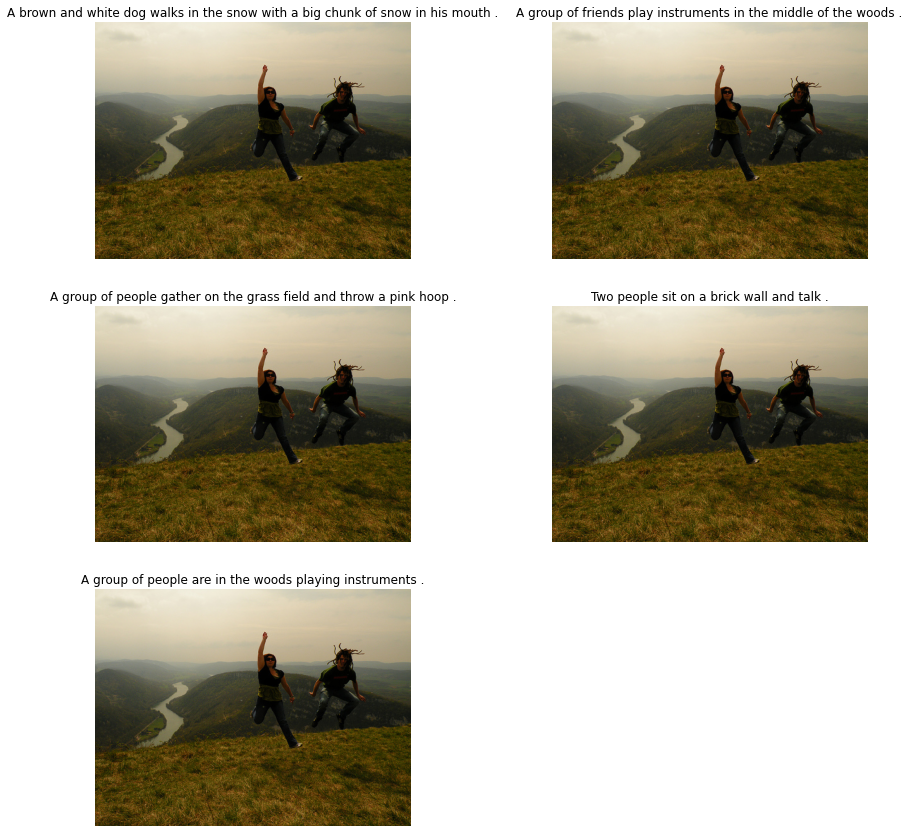

In [63]:
# Создадим фигуру размером 15 на 20 дюймов
pic_box = plt.figure(figsize=(15,20))
 
for i, (txt, img) in enumerate(dict_.items()):
    picture = cv2.imread('/content/drive/MyDrive/datasets/search_photo/test_images/' + img)
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
    pic_box.add_subplot(4,2,i+1).set_title(txt)
    plt.imshow(picture)
    plt.axis('off')
 
plt.show()

На разнообразные запросы выдается одна и та же фотография, это говорит о неэффективности векторизации текстов и,возможно, фотографий. С учетом малого количества данных для тренировки моделей, следует воспользоваться специальной моделью, разработанной для решения поставленной задачи. Этой моделью будет Clip

## openAI CLIP

In [64]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1lkcdl16
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-1lkcdl16
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369409 sha256=8156610f1456487e2ddc6a3b2cee6cfb2fc8ab267352fadd092aec4877eac0a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-bvmb00op/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully built clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
import torch
import clip
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [66]:
# Установка openAI CLIP (с использованием GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 233MiB/s]


In [67]:
# Собираем список названий фото
img_names = []
for filename in os.listdir('/content/drive/MyDrive/datasets/search_photo/test_images/'):
    img_names.append(filename)


In [68]:
# Создаем функцию для преобразования фото и текста в вектора и с помощью косинусной близости выбираем наиболее близкий к тексту вектор изображения
def image_search(sample, img_names, kids_words):

    lst_error = []

    images = [
        preprocess(
            Image.open(f"/content/drive/MyDrive/datasets/search_photo/test_images/{img_id}")
        ) for img_id in img_names
    ]

    image_input = torch.tensor(np.stack(images)).to(device)

    test_row = test_query.sample(sample)
    tkns = test_row['query_text'].values.tolist()

    for txt in tkns:
        for word in kids_words:
            if word in txt.lower().split(' '):
                lst_error.append(txt) 
                tkns.remove(txt)       
                break

    if len(tkns) > 0:
        text = clip.tokenize(tkns).to(device)

    with torch.no_grad():
        logits_per_image, logits_per_text = model(image_input, text)
        probs = logits_per_text.softmax(dim=-1).cpu().numpy()

    return tkns, lst_error, probs

txt, errors, probs = image_search(10, img_names, kids_words)

A little girl with a hat sits between a woman 's feet in the sand in front of a pair of colorful tents . - This image is unavailable in your country in compliance with local laws

Two boys in swimsuits standing under running water . - This image is unavailable in your country in compliance with local laws



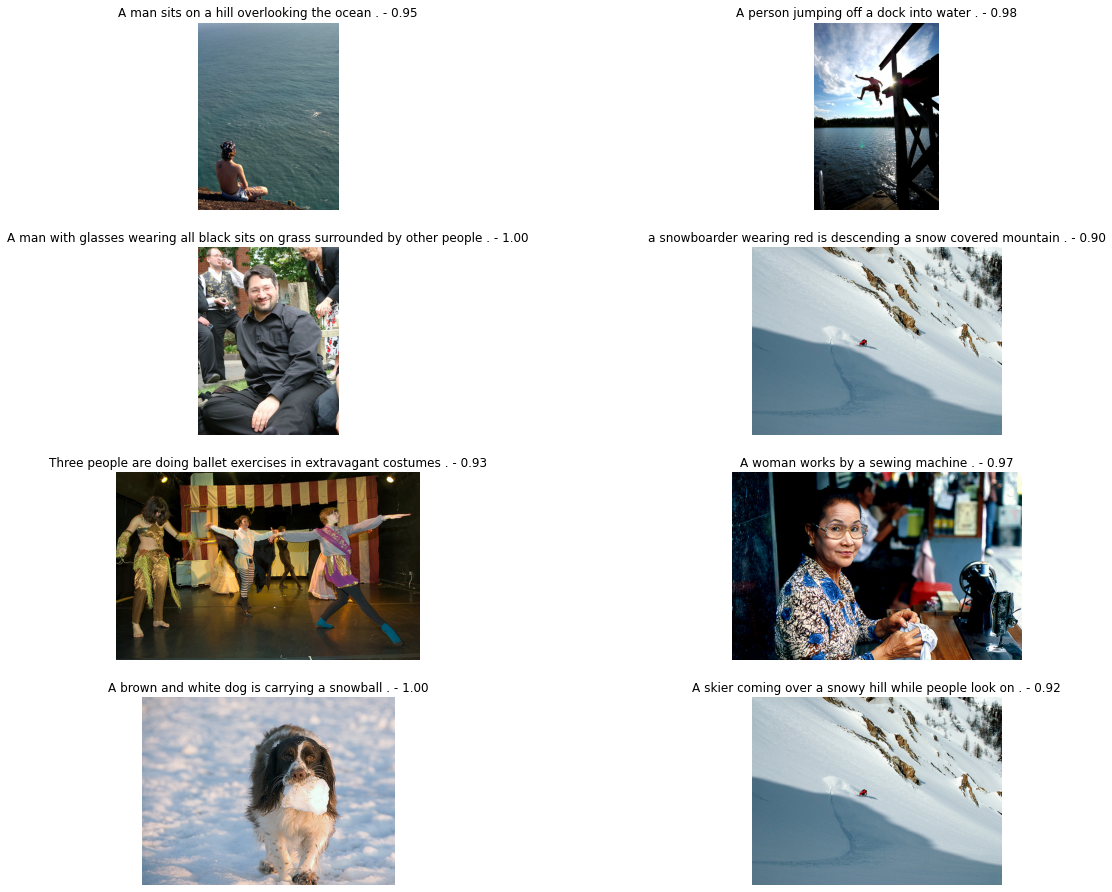

In [69]:
# Функция для отображения наиболее релевантных снимков определенному запросу
def show_pictures(txt, errors, probs, img_names):
    if len(errors) > 0:
        for elem in errors:
            print(f'{elem} - This image is unavailable in your country in compliance with local laws\n')

  
  if len(txt) > 0:
    pic_box = plt.figure(figsize=(20,20))
    
    for index, text in enumerate(txt):
        max_arg = np.argmax(probs[index])
        prob = probs[index][max_arg]
        img_name = img_names[max_arg]
        picture = cv2.imread('/content/drive/MyDrive/datasets/search_photo/test_images/' + img_name)
        picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB)
        pic_box.add_subplot(5,2,index+1).set_title(f'{text} - {prob:.2f}')
        plt.axis('off')
        plt.imshow(picture)  

show_pictures(txt, errors, probs, img_names)

## Итог

Из-за недостатка тренировочных данных построить собственную адекватную вероятностную модель не получилось, однако для данных целей уже была предобучена модель openai Clip, которая показала отличный результат на тестовых данных. Все подобранные фотографии соответствуют их текстовому описанию. 